In [1]:
%pip install numpy pandas kaggle torch opencv-python pillow tqdm torchvision facenet-pytorch==2.5.0 matplotlib --only-binary=:all:

Note: you may need to restart the kernel to use updated packages.


In [2]:
!chmod 600 ~/.kaggle/kaggle.json

In [18]:
# !kaggle competitions download -c deepfake-detection-challenge

In [19]:
#!unzip deepfake-detection-challenge.zip

In [1]:
#!kaggle datasets download -d timesler/facenet-pytorch-vggface2
#!unzip facenet-pytorch-vggface2.zip -d facenet-pytorch-vggface2

In [3]:
from facenet_pytorch.models.inception_resnet_v1 import get_torch_home
torch_home = get_torch_home()

# Copy model checkpoints to torch cache so they are loaded automatically by the package
!mkdir "%torch_home%\checkpoints"
!copy facenet-pytorch-vggface2\20180402-114759-vggface2-logits.pth "%torch_home%\checkpoints\vggface2_DG3kwML46X.pt"
!copy facenet-pytorch-vggface2\20180402-114759-vggface2-features.pth "%torch_home%\checkpoints\vggface2_G5aNV2VSMn.pt"

A subdirectory or file %torch_home%\checkpoints already exists.


        1 file(s) copied.
        1 file(s) copied.


In [4]:
import os
import glob
import json
import torch
import cv2
from PIL import Image
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face

import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

if torch.cuda.is_available():
    device = 'cuda'
    torch.set_default_device('cuda')
else:
    device = 'cpu'
print(f'Running on device: {device}')

Running on device: cuda


In [5]:
torch.cuda.is_available()

True

In [6]:
TRAIN_DIR = 'DFDC/deepfake-detection-challenge/train_sample_videos'

BATCH_SIZE = 1
SCALE = 0.25
N_FRAMES = None # The number of frames extracted from each video, 'None' means get all available frames

In [7]:
# Source: https://www.kaggle.com/timesler/facial-recognition-model-in-pytorch
class DetectionPipeline:
    """Pipeline class for detecting faces in the frames of a video file."""

    def __init__(self, detector, n_frames=None, batch_size=60, resize=None):
        """Constructor for DetectionPipeline class.

        Keyword Arguments:
            n_frames {int} -- Total number of frames to load. These will be evenly spaced
                throughout the video. If not specified (i.e., None), all frames will be loaded.
                (default: {None})
            batch_size {int} -- Batch size to use with MTCNN face detector. (default: {32})
            resize {float} -- Fraction by which to resize frames from original prior to face
                detection. A value less than 1 results in downsampling and a value greater than
                1 result in upsampling. (default: {None})
        """
        self.detector = detector
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.resize = resize

    def __call__(self, filename):
        """Load frames from an MP4 video and detect faces.

        Arguments:
            filename {str} -- Path to video.
        """
        # Create video reader and find length
        v_cap = cv2.VideoCapture(filename)
        v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT))

        # Pick 'n_frames' evenly spaced frames to sample
        if self.n_frames is None:
            sample = np.arange(0, v_len)
        else:
            sample = np.linspace(0, v_len - 1, self.n_frames).astype(int)

        # Loop through frames
        faces = []
        frames = []
        for j in range(v_len):
            success = v_cap.grab()
            if j in sample:
                # Load frame
                success, frame = v_cap.retrieve()
                if not success:
                    continue
                frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                frame = Image.fromarray(frame)

                # Resize frame to desired size
                if self.resize is not None:
                    frame = frame.resize([int(d * self.resize) for d in frame.size])
                frames.append(frame)

                # When batch is full, detect faces and reset frame list
                if len(frames) % self.batch_size == 0 or j == sample[-1]:
                    faces.extend(self.detector(frames))
                    frames = []

        v_cap.release()

        return faces

In [8]:
# Source: https://www.kaggle.com/timesler/facial-recognition-model-in-pytorch

def process_faces(faces, feature_extractor):
    # Filter out frames without faces
    faces = [f for f in faces if f is not None]
    if len(faces) == 0:
        return None
    faces = torch.cat(faces).to(device)

    # Generate facial feature vectors using a pretrained model
    embeddings = feature_extractor(faces)

    # Calculate centroid for video and distance of each face's feature vector from centroid
    centroid = embeddings.mean(dim=0)
    x = (embeddings - centroid).norm(dim=1).cpu().numpy()

    return x

In [9]:
# Load face detector
face_detector = MTCNN(margin=14, keep_all=True, factor=0.5, device=device).eval()

# Load facial recognition model
feature_extractor = InceptionResnetV1(pretrained='vggface2', device=device).eval()

# Define face detection pipeline
detection_pipeline = DetectionPipeline(detector=face_detector, n_frames=N_FRAMES, batch_size=BATCH_SIZE, resize=SCALE)

In [44]:
# Get the paths of all train videos

#glob.glob(os.path.join(TRAIN_DIR, '*.mp4'))
all_train_videos = [os.path.normpath(path) for path in glob.glob(os.path.join(TRAIN_DIR, '*.mp4'))]

# Get path of metadata.json
metadata_path = TRAIN_DIR + '/metadata.json'

# Get metadata
with open(metadata_path, 'r') as f:
    metadata = json.load(f)

In [11]:
df = pd.DataFrame(columns=['filename', 'distance', 'label'])

with torch.no_grad():
    for path in tqdm(all_train_videos):
        file_name = os.path.basename(path)

        # Detect all faces occur in the video
        faces = detection_pipeline(path)

        # Calculate the distances of all faces' feature vectors to the centroid
        distances = process_faces(faces, feature_extractor)
        if distances is None:
            continue

        for distance in distances:
            row = [
                file_name,
                distance,
                1 if metadata[file_name]['label'] == 'FAKE' else 0
            ]

            # Append a new row at the end of the data frame
            df.loc[len(df)] = row

  0%|          | 0/400 [00:00<?, ?it/s]

In [15]:
df.head()

,filename,distance,label
0,aagfhgtpmv.mp4,0.582341,1
1,aagfhgtpmv.mp4,0.585332,1
2,aagfhgtpmv.mp4,0.615475,1
3,aagfhgtpmv.mp4,0.624315,1
4,aagfhgtpmv.mp4,0.629985,1


In [17]:
df.to_csv('train.csv', index=False)

**Training**

In [20]:
TRAIN_PATH = 'train.csv'
SAVE_PATH = 'model.pth'

TEST_SIZE = 0.3
RANDOM_STATE = 128
EPOCHS = 200
BATCH_SIZE = 64
LR = 1e-4

In [21]:
class LogisticRegression(nn.Module):
    def __init__(self, D_in=1, D_out=1):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(D_in, D_out)

    def forward(self, x):
        y_pred = self.linear(x)

        return y_pred

    def predict(self, x):
        result = self.forward(x)

        return torch.sigmoid(result)

In [22]:
def shuffle_data(X, y):
    assert len(X) == len(y)

    p = np.random.permutation(len(X))

    return X[p], y[p]

In [23]:
train_df = pd.read_csv(TRAIN_PATH)
train_df.head()

,filename,distance,label
0,aagfhgtpmv.mp4,0.582341,1
1,aagfhgtpmv.mp4,0.585332,1
2,aagfhgtpmv.mp4,0.615475,1
3,aagfhgtpmv.mp4,0.624315,1
4,aagfhgtpmv.mp4,0.629985,1


In [24]:
label_count = train_df.groupby('label').count()['filename']
print(label_count)

# Use pos_weight value to overcome imbalanced dataset.
# https://pytorch.org/docs/stable/nn.html#torch.nn.BCEWithLogitsLoss
pos_weight = torch.ones([1]) * label_count[0]/label_count[1]
print('pos_weight:', pos_weight)

label
0    27575
1    99808
Name: filename, dtype: int64
pos_weight: tensor([0.2763], device='cuda:0')


In [25]:
X = train_df['distance'].to_numpy()
y = train_df['label'].to_numpy()

In [26]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=y)

In [27]:
X_train = torch.tensor(X_train).to(device).unsqueeze(dim=1).float()
X_val = torch.tensor(X_val).to(device).unsqueeze(dim=1).float()
y_train = torch.tensor(y_train).to(device).unsqueeze(dim=1).float()
y_val = torch.tensor(y_val).to(device).unsqueeze(dim=1).float()

In [28]:
classifier = LogisticRegression().to(device)  # Move the model to the same device as the data
criterion = nn.BCEWithLogitsLoss(reduction='mean', pos_weight=pos_weight.to(device))  # Move pos_weight to the same device
optimizer = optim.Adam(classifier.parameters(), lr=LR)

n_batches = np.ceil(len(X_train) / BATCH_SIZE).astype(int)
losses = np.zeros(EPOCHS)
val_losses = np.zeros(EPOCHS)
best_val_loss = 1e7

for e in tqdm(range(EPOCHS)):
    batch_losses = np.zeros(n_batches)
    pbar = tqdm(range(n_batches))
    pbar.desc = f'Epoch {e+1}'
    classifier.train()

    # Shuffle training data
    X_train, y_train = shuffle_data(X_train, y_train)

    for i in pbar:
        # Get batch.
        X_batch = X_train[i*BATCH_SIZE:min(len(X_train), (i+1)*BATCH_SIZE)]
        y_batch = y_train[i*BATCH_SIZE:min(len(y_train), (i+1)*BATCH_SIZE)]

        # Make prediction.
        y_pred = classifier(X_batch)

        # Compute loss.
        loss = criterion(y_pred, y_batch)
        batch_losses[i] = loss

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Compute batch loss (average)
    losses[e] = batch_losses.mean()

    # Compute val loss
    classifier.eval()
    y_val_pred = classifier(X_val)
    val_losses[e] = criterion(y_val_pred, y_val)

    # Save model based on the best (lowest) val loss.
    if val_losses[e] < best_val_loss:
        print('Found a better checkpoint!')
        torch.save(classifier.state_dict(), SAVE_PATH)
        best_val_loss = val_losses[e]


    # Display some information in progress-bar.
    pbar.set_postfix({
        'loss': losses[e],
        'val_loss': val_losses[e]
    })

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

Found a better checkpoint!


  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

  0%|          | 0/1394 [00:00<?, ?it/s]

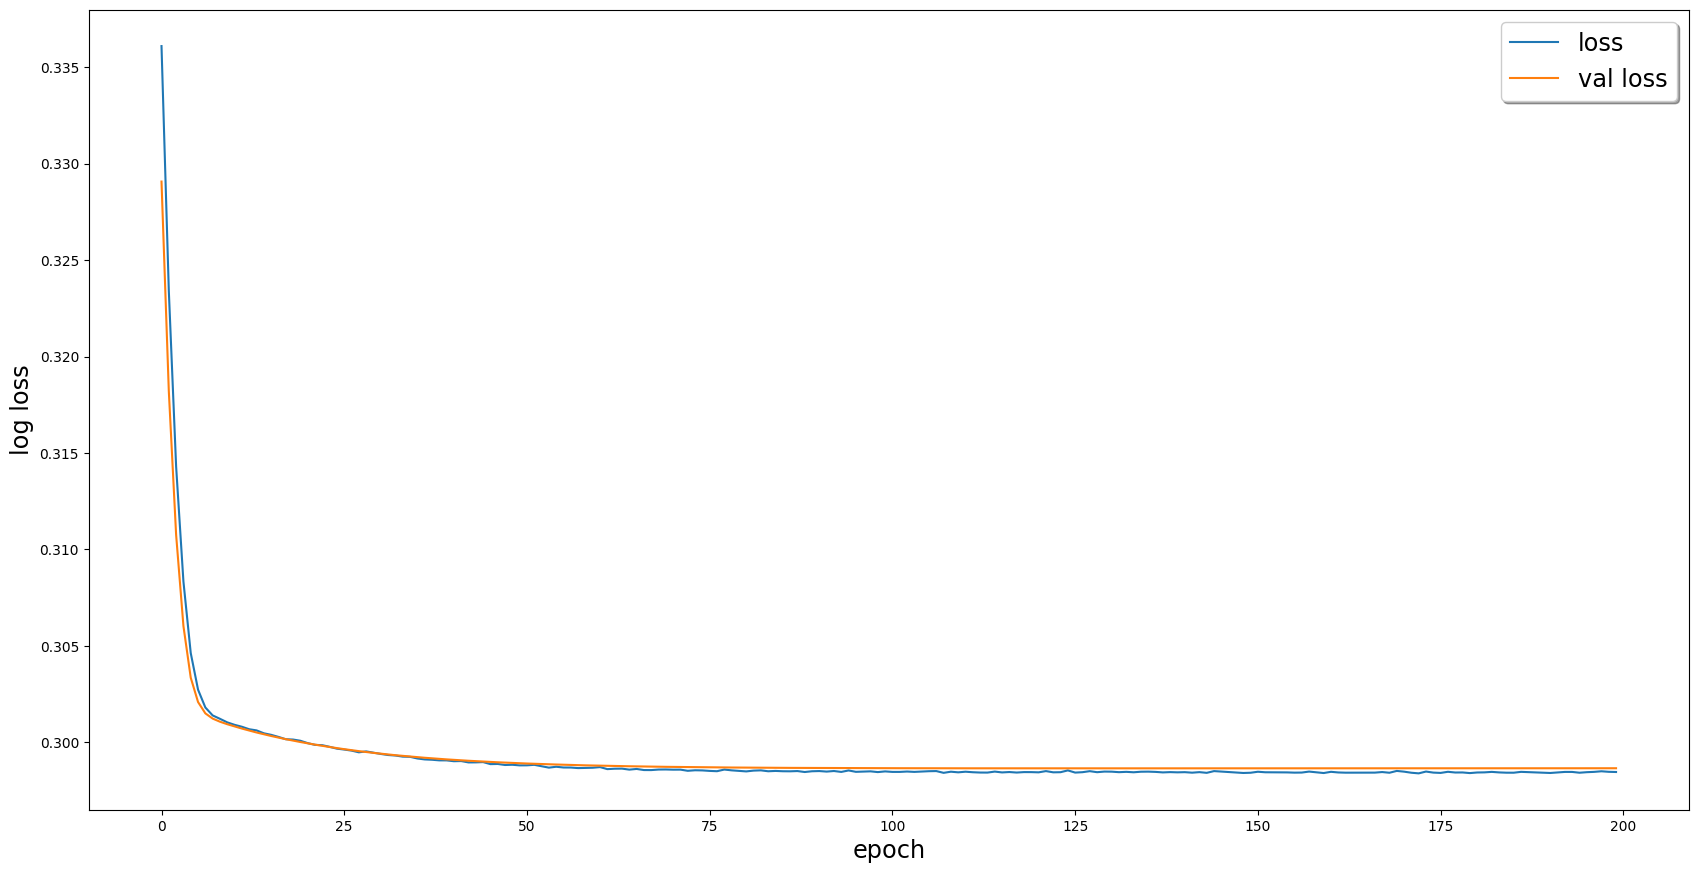

In [29]:
fig = plt.figure(figsize=(16, 8))
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(np.arange(EPOCHS), losses)
ax.plot(np.arange(EPOCHS), val_losses)
ax.set_xlabel('epoch', fontsize='xx-large')
ax.set_ylabel('log loss', fontsize='xx-large')
ax.legend(
    ['loss', 'val loss'],
    loc='upper right',
    fontsize='xx-large',
    shadow=True
)
plt.show()

**Validation**

In [30]:
without_weight_criterion = nn.BCELoss(reduction='mean')

classifier.eval()
with torch.no_grad():
    y_val_pred = classifier.predict(X_val)
    val_loss = without_weight_criterion(y_val_pred, y_val)

print('val loss:', val_loss.detach().cpu().numpy())

val loss: 0.6906633


In [31]:
y_val_pred.detach().cpu()

tensor([[0.5299],
        [0.4695],
        [0.4364],
        ...,
        [0.3262],
        [0.4630],
        [0.5231]])

[]

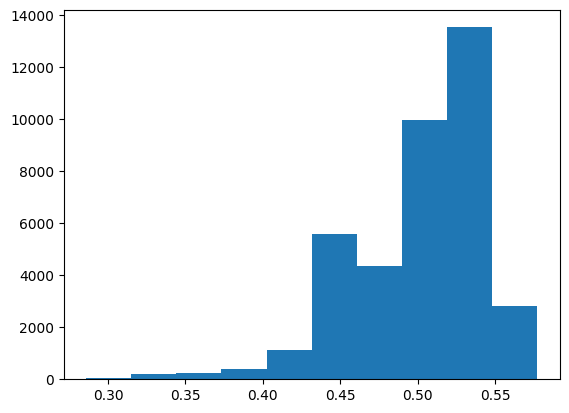

In [33]:
plt.hist(y_val_pred.squeeze(dim=-1).detach().cpu())
plt.plot()